# Exemplo de Regressão Logística usando Softmax (Iris dataset) implementação matricial

Utiliza uma rede neural de uma camada e função Softmax. A programação da rede, assim
como o seu treinamento e predição utilizam programação matricial, sem fazer uso de
bibliotecas de *machine learning*.

O uso de apenas dois atributos permite visualização do espaço de atributos


### Este tutorial foi inspirado na documentação do sklearn : [Logistic Regression 3-class Classifier](http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py)

Objetivo deste exemplo é codificar o método de Regressão Logística utilizando Softmax e
gradiente descendente. As bibliotecas usadas são mínimas, principalmente as funções básicas
matriciais dos pacotes `NumPy` e `Scipy`. As demais bibliotecas são usadas neste exemplo apenas para: `pandas` - para imprimir a matriz de confusão; `sklearn` - para carregar o conjunto de
dados Iris; `matplotlib` - para mostrar gráfico e imagens.

In [2]:
import numpy as np
import scipy.sparse

import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline


Using Theano backend.


## Iris Flower Dataset

[Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set): The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

In [3]:
from sklearn import linear_model, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:,:2]  # we only take the first two features: length and width of the sepals
X = np.hstack([np.ones((150,1)),X]) # incluído X00 como 1 para gerar bias no W
Y = iris.target



### Visualizando o dataset

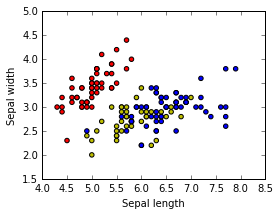

In [4]:
plt.figure(1, figsize=(4, 3))
colors = np.array(['r','y','b'])
plt.scatter(X[:, 1], X[:, 2], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

The below function converts integer class coding, where there is a unidimensional array of labels into a one-hot varient, where the array is size m (examples) x k (classes).

In [5]:
def oneHotIt(Y):
    m = Y.shape[0]
    Y_oh = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    Y_oh = np.array(Y_oh.todense()).T
    return Y_oh

Gerando vetor de rótulos no formato one-hot 

In [6]:
Y_oh = oneHotIt(Y)

Now we set the loaded data as our x and y variables for both the train and test sets.

![](../figures/w0bias.png)
![](https://sebastianraschka.com/images/faq/softmax_regression/logistic_regression_schematic.png)

### Before we can get to training our model using the data, we will have to define a few functions that the training and testing process can use.

Função que calcula a transformação `softmax`:
Recebe como entrada uma matriz dos *scores* no formato: linhas é igual número de amostras `n`
e colunas igual ao número de classes `k`.

`Softmax` calcula um exponencial normalizado. 

No resultado, a soma de cada linha referente à amostra `j` é 1, pois cada coluna
representa a probabilidade de ser cada a classe `k`. 

$$ S^{(j)} = \frac{\exp(\boldsymbol{z}^{(j)})}{\sum_{i=0}^{k-1} \exp(z^{(j)}_{i})} $$

![](../figures/softmax_matrizes.png)

In [7]:
def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input z: scores; shape: samples rows x classes columns
    # output sm: same shape of input
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=1,keepdims=True)
    return S

Here we determine the predictions for each class when given a set of input data:
X: n amostras x m attributes
W: m attributes x k classes
Y_hat: n amostras x k classes

In [8]:
def predict(X,W):
    S = softmax(X.dot(W))
    Y_hat = np.argmax(S,axis=1)
    return Y_hat

### Este é o laço principal da Regressão Logística por Softmax

Os pesos são inicializados em zero, sem fator de regularização.
Em cada iteração, a função a ser minimizada é calculada e os pesos são ajustados
pelo técnica de gradiente descendente.

A função a ser minimizada é a função $J$ de perda, que é baseada na Entropia Cruzada (*Cross Entropy*). Dado um conjunto de **amostras anotadas**, isto é, amostras $\boldsymbol{X}$ com
classe $\boldsymbol{Y}$, encontrar os pesos $\boldsymbol{W}$ que minimizam $J$:

$$ J_{\boldsymbol{X,Y}_{TRUE}}(\boldsymbol{W}) = -\frac{1}{n} \sum \boldsymbol{Y}_{TRUE} \odot \log{\boldsymbol{S}(\boldsymbol{XW})}$$
onde $\odot$ é multiplicação ponto-a-ponto de matrizes.

A minimização é feita através do método de gradiente descendente. O gradiente de $J$ é dado por:

$$ \boldsymbol{\Delta J(W)} = - \frac{1}{n} \boldsymbol{X}^T (\boldsymbol{Y}_{TRUE} - \boldsymbol{S(XW)}) $$ 

Os pesos são então ajustados em cada *batch* pela equação onde $\eta$ é denominado de
taxa de aprendizagem: *learning rate*:

$$ \boldsymbol{W} = \boldsymbol{W} - \eta \boldsymbol{\Delta J(W)} $$ 

A cada iteração no programa de minimização abaixo, os pesos são ajustados aplicando-se o
gradiente descendente utilizando todo o conjunto de treinamento. Este esquema é denominado
de "batch gradient descent".

No programa a seguir, o $J$ é implementado pela variável `loss` e o gradiente $\Delta J$ 
é implementado pela variável `Grad`.

In [29]:
n = X.shape[0] # number of training examples
m = X.shape[1] # number of attributes (features + 1(bias))
k = 3          # number of classes
W = np.zeros([m,k]) # n. de linhas é igual a número de atributos (features, pixels)
print 'W.shape:', W.shape
print 'n:',n
lam = 0 # 1 sem regularização
iterations = 10000
learningRate = 1e-3 * 150
losses = []
for i in range(iterations):
    scores = X.dot(W)
    S = softmax(scores)
    loss = (-1. / n) * np.sum(Y_oh * np.log(S)) + (lam/2) * (W*W).sum() 
    Grad = (-1. / n) * (X.T).dot(Y_oh - S) + lam*W 
    W = W - (learningRate * Grad)
    losses.append(loss)
    #print 'loss:',loss, loss2
print 'W:',W
print 'S.shape:', S.shape
print 'loss.shape:',loss.shape
print 'Grad.shape:',Grad.shape
print 'W.shape:',W.shape
print 'Final loss:',loss
# usual dar loss de 317.25

W.shape: (3, 3)
n: 150
W: [[ 3.90753346  3.66374796 -7.57128142]
 [-4.78613816  1.57399916  3.212139  ]
 [ 7.28592998 -3.82148989 -3.46444009]]
S.shape: (150, 3)
loss.shape: ()
Grad.shape: (3, 3)
W.shape: (3, 3)
Final loss: 0.402942528538


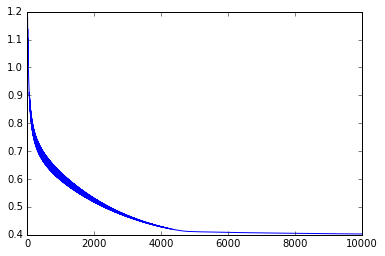

In [28]:
plt.plot(losses)

### Now that we have trained our model, we can see how well it is able to perform on both the training and test sets:

In [30]:
def getAccuracy(X,W, Y):
    Y_hat = predict(X,W)
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

print 'Training Accuracy: ', getAccuracy(X,W,Y)


Training Accuracy:  0.826666666667


## Visualizando a regiões do classificador no espaço de atributos

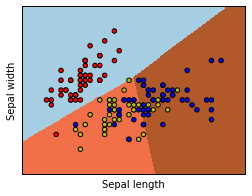

In [31]:
h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 1].min() - .5, X[:, 1].max() + .5
y_min, y_max = X[:, 2].min() - .5, X[:, 2].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid = np.hstack([np.ones((X_grid.shape[0],1)),X_grid]) # incluído X00 como 1 para gerar bias no W

Z = predict(X_grid, W)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
colors = np.array(['r','y','b'])
plt.scatter(X[:, 1], X[:, 2], c=colors[Y], edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()